In [16]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pyhf
import pyhf.readxml
import os
from ipywidgets import interact, fixed
import scipy.stats
import json

In [3]:
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=False))

In [4]:
def default_flatname(branchname, fieldname, index):
    out = branchname.replace(".", "_")
    if not isinstance(branchname, str):
        out = branchname.decode("utf-8")
    if fieldname is not None:
        fieldname.replace(".", "_")
        out += "_" + fieldname
    if index != ():
        out += "[" + "][".join(str(x) for x in index) + "]"
    return out

In [6]:
cuts = [
    "de_status > 0",
    "de_t0 > 700",
    "de_t0 < 1695",
    "deent_td > 0.577350",
    "deent_td < 1.000",
    "deent_d0 < 105",
    "-deent_d0 < 80",
    "(deent_d0 + 2./deent_om) > 450",
    "(deent_d0 + 2./deent_om) < 680",
    "dequal_TrkQual > 0.8",
    "dequal_TrkPID > 0.95",
    "ue_status <= 0",
    "deent_mom > 95",
    "(bestcrv < 0 | ((-de_t0 + crvinfo__timeWindowStart_best) > 50 | (de_t0-crvinfo__timeWindowStart_best) > 150.0))",
#     "is_triggered"
]

cut = " & ".join(cuts)

In [7]:
# file = uproot.open("root_files/trkana-ensemble-run7i-MC.root")
# trkananeg = file["TrkAnaNeg"]["trkana"]
# df_dio = trkananeg.pandas.df(flatname=default_flatname, flatten=False)
# df_dio["is_triggered"] = (df_dio["trigbits"].values & 0x208) > 0
# df_dio["crvinfo__timeWindowStart_best"] = [twstart[index] 
#                                        if index>=0 else 0
#                                        for index, twstart in zip(df_dio["bestcrv"], df_dio["crvinfo__timeWindowStart"])]
# df_dio["demcgen_mom"] = np.sqrt(df_dio["demcgen_momx"]**2+df_dio["demcgen_momy"]**2+df_dio["demcgen_momz"]**2)
# df_dio["weight"] = 1
# df_dio = df_dio.query(cut + "& demcgen_gen == 7")

In [8]:
# file = uproot.open("root_files/ce.root")
# trkananeg = file["TrkAnaNeg"]["trkana"]
# df_ce = trkananeg.pandas.df(flatname=default_flatname, flatten=False)
# df_ce["is_triggered"] = (df_ce["trigbits"].values & 0x208) > 0
# df_ce["crvinfo__timeWindowStart_best"] = [twstart[index] 
#                                        if index>=0 else 0
#                                        for index, twstart in zip(df_ce["bestcrv"], df_ce["crvinfo__timeWindowStart"])]
# df_ce["demcgen_mom"] = np.sqrt(df_ce["demcgen_momx"]**2+df_ce["demcgen_momy"]**2+df_ce["demcgen_momz"]**2)
# df_ce["weight"] = 1
# df_ce = df_ce.query(cut)

In [9]:
run_files = ["root_files/trkana-ensemble-run1i-MC.root", 
             "root_files/trkana-ensemble-run2i-MC.root", 
             "root_files/trkana-ensemble-run3i-MC.root", 
             "root_files/trkana-ensemble-run4i-MC.root",
             "root_files/trkana-ensemble-run5i-MC.root",
             "root_files/trkana-ensemble-run6i-MC.root",
             "root_files/trkana-ensemble-run7i-MC.root"]

In [10]:
df_datas = []
for f in run_files:
    file = uproot.open(f)
    trkananeg = file["TrkAnaNeg"]["trkana"]

    df_data = trkananeg.pandas.df(flatname=default_flatname, flatten=False)
    df_data["is_triggered"] = (df_data["trigbits"].values & 0x208) > 0
    df_data["crvinfo__timeWindowStart_best"] = [twstart[index] 
                                           if index>=0 else 0
                                           for index, twstart in zip(df_data["bestcrv"], df_data["crvinfo__timeWindowStart"])]
    df_data["demcgen_mom"] = np.sqrt(df_data["demcgen_momx"]**2+df_data["demcgen_momy"]**2+df_data["demcgen_momz"]**2)
    df_data["weight"] = 1
    df_datas.append(df_data.query(cut))

In [12]:
# for i_df, df_data in enumerate(df_datas):

#     bkg_nominal = TH1F('bkg_nominal', '', 80, 95, 115)
#     fill_hist(bkg_nominal, df_dio['deent_mom'])

#     sig_nominal = TH1F('sig_nominal', '', 80, 95, 115)
#     fill_hist(sig_nominal, df_ce['deent_mom'])

#     data_nominal = TH1F('data_nominal', '', 80, 95, 115)
#     fill_hist(data_nominal, df_data['deent_mom'])

#     epsilon = 1e-20
#     for i in range(bkg_nominal.GetNbinsX()+1):
#         bkg_nominal.SetBinContent(i, bkg_nominal.GetBinContent(i)+epsilon)
#         sig_nominal.SetBinContent(i, sig_nominal.GetBinContent(i)+epsilon)
#         data_nominal.SetBinContent(i, data_nominal.GetBinContent(i)+epsilon)

#     meas = TFile('root_files/meas%i.root' % i_df, 'RECREATE')
#     bkg_nominal.Write()
#     sig_nominal.Write()
#     data_nominal.Write()
#     meas.Close()

In [13]:
bounds = [[0.5, 1.5, 0.1], [0.0, 3.0, 0.1], [0.0, 0.05, 0.001]]
labels = ['DIO', 'CE']

In [14]:


def poisson_err(x):
    # From http://www.pp.rhul.ac.uk/~cowan/atlas/ErrorBars.pdf
    upper = 0.5*scipy.stats.chi2.ppf(1-0.158655, 2*(x+1))
    lower = 0.5*scipy.stats.chi2.ppf(0.158655, 2*x)
    return x-lower, upper-x

def get_mc_counts(pars):
    deltas, factors = pdf._modifications(pars)
    allsum = pyhf.tensorlib.concatenate(
        deltas + [pyhf.tensorlib.astensor(pdf.nominal_rates)]
    )
    nom_plus_delta = pyhf.tensorlib.sum(allsum, axis=0)
    nom_plus_delta = pyhf.tensorlib.reshape(
        nom_plus_delta, (1,) + pyhf.tensorlib.shape(nom_plus_delta)
    )
    allfac = pyhf.tensorlib.concatenate(factors + [nom_plus_delta])
    return pyhf.tensorlib.product(allfac, axis=0)


animate_plot_pieces = None


def init_plot(fig, ax, par_settings):
    global animate_plot_pieces

    nbins = sum(list(pdf.config.channel_nbins.values()))
    x = np.arange(nbins)
    data = np.zeros(nbins)
    items = []
    for i in [3, 2, 1, 0]:
        items.append(ax.bar(x, data, 1, alpha=1.0))
        
    data_hist = np.array(workspace.data(pdf, with_aux=False))
    animate_plot_pieces = (
        items,
        ax.errorbar(x, data_hist, yerr=poisson_err(data_hist), fmt='o', color='k', zorder=99)
    )


def animate(ax=None, fig=None, **par_settings):
    global animate_plot_pieces
    items, obs = animate_plot_pieces
    pars = pyhf.tensorlib.astensor(pdf.config.suggested_init())
    for k, v in par_settings.items():
        pars[par_name_dict[k]] = v

    mc_counts = get_mc_counts(pars)
    rectangle_collection = zip(*map(lambda x: x.patches, items))

    for rectangles, binvalues in zip(rectangle_collection, mc_counts[:, 0].T):
        offset = 0
        for sample_index in [1, 0]:
            rect = rectangles[sample_index]
            binvalue = binvalues[sample_index]
            rect.set_y(offset)
            rect.set_height(binvalue)
            offset += rect.get_height()

    fig.canvas.draw()
    
    
ces = []
import tensorflow as tf
def plot(ax=None, order=[3, 2, 1, 0], errors=[], **par_settings):
    pars = pyhf.tensorlib.astensor(pdf.config.suggested_init())
    for k, v in par_settings.items():
        pars[par_name_dict[k]] = v

    mc_counts = get_mc_counts(pars)
    bottom = None
    # nb: bar_data[0] because evaluating only one parset
    for i, sample_index in enumerate(order):
        data = mc_counts[sample_index][0]
        x = np.arange(95,115,0.25)
        if i == 1:
            ces.append(sum(data))
        ax.bar(x, data, 0.25, bottom=bottom, alpha=1.0, label=labels[i]+(r": $%.2f\pm%.2f$ events" % (sum(data), sum(data)*errors[i+1])))
        bottom = data if i == 0 else bottom + data
    
    data_hist = np.array(workspace.data(pdf, with_aux=False))
    ax.errorbar(x, data_hist, yerr=poisson_err(data_hist), fmt='o', color='k', zorder=99)
    

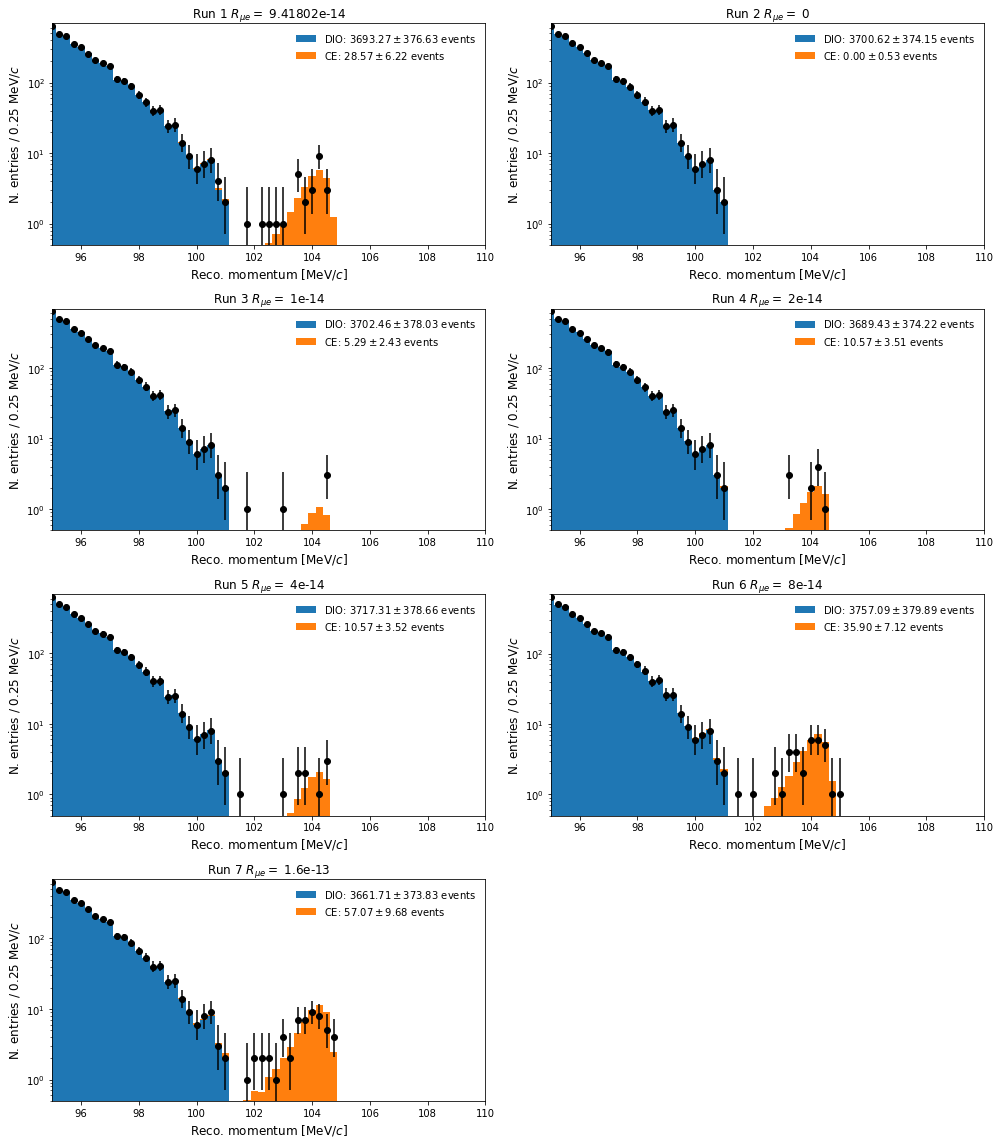

In [17]:
%matplotlib inline
fig, ax = plt.subplots(4,2, figsize=(14, 16))

r_mues = [9.418019e-14,
          0,
          1e-14,
          2e-14,
          4e-14,
          8e-14,
          1.6e-13]

i=0
for row in range(4):
    for column in range(2):
        if i < 7:
            with open("meas.json") as spec_file:
                spec = json.load(spec_file)
            spec['observations'][0]['data'] = np.histogram(df_datas[i]['deent_mom'], bins=80, range=(95,115))[0].tolist()
            workspace = pyhf.Workspace(spec)
            pdf = workspace.model(measurement_name='meas')
            
            par_name_dict = {k: v["slice"].start for k, v in pdf.config.par_map.items()}
            all_par_settings = {
                n[0]: tuple(m)
                for n, m in zip(
                    sorted(reversed(list(par_name_dict.items())), key=lambda x: x[1]),
                    bounds,
                )
            }
            default_par_settings = {n[0]: sum(tuple(m)) / 2.0 for n, m in all_par_settings.items()}
            
            data = workspace.data(pdf)
            workspace.get_measurement(measurement_name='meas')
            best_fit = pyhf.infer.mle.fit(data, pdf, return_uncertainties=True)
            plot(ax=ax[row][column], order=[0,1], errors=best_fit[:, 1]/best_fit[:, 0], **{k: best_fit[:, 0][v] for k,v in par_name_dict.items()});
            ax[row][column].set_title("Run %i $R_{\mu e} =$ %g" % (i+1, r_mues[i]))
            ax[row][column].set_ylim(bottom=0.5)
            ax[row][column].set_xlim(95,110)
            ax[row][column].set_yscale('log')    
            ax[row][column].set_xlabel(r"Reco. momentum [MeV/$c$]", fontsize=12)
            ax[row][column].set_ylabel(r"N. entries / 0.25 MeV/$c$", fontsize=12)
            ax[row][column].legend(frameon=False)
            i+=1
ax[-1, -1].axis('off')
fig.tight_layout()

In [ ]:
fit_ces = []
for df in df_datas:
    fit_ces.append(len(df.query("demcgen_gen==43")))
    
plt.scatter(ces, fit_ces, marker='o')
plt.xlim(0,60)
plt.ylim(0,60)
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")


In [30]:
%matplotlib widget
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
ax.set_ylim(0, 1.5 * np.max(workspace.data(pdf, with_aux=False)))
init_plot(fig, ax, default_par_settings)
interact(animate, fig=fixed(fig), ax=fixed(ax), **all_par_settings);
fig.tight_layout()
ax.set_ylim(bottom=0.5)
ax.set_xlim(0, 80)
ax.set_yscale('log')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=1.0, description='lumi', max=1.5, min=0.5), FloatSlider(value=1.5, des…